## Loading the data and Libraries

In [ ]:
!nvidia-smi

Wed Dec 16 14:58:29 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import pandas as pd
import operator 
import tensorflow as tf
import numpy as np
import seaborn as sns
import gensim.downloader as api
from gensim.models import KeyedVectors
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import nltk
from sklearn.metrics import log_loss, confusion_matrix, roc_auc_score, precision_score, recall_score
import warnings
from tensorflow.keras.utils import plot_model
from tensorflow.keras import Sequential, layers, losses, callbacks, metrics, Model, optimizers, utils
from tensorflow.keras.layers import Input, LSTM, Flatten, BatchNormalization, Dense, Activation, Concatenate
import tensorflow.keras.backend as K
import tensorflow_hub as hub
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import operator 
warnings.filterwarnings('ignore')
tqdm.pandas()

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Data/Quora/input/result_version_2.csv')
df = df.sample(frac=1, random_state=1).reset_index(drop=True)
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,selected_1,selected_2,selected_3,selected_4,selected_5,selected_6,selected_7,selected_8,selected_9,selected_10
0,237030,33086,348102,how can i stop playing video games?,should i stop playing video games with my child?,0,4.0,4.0,2.0,0.999980,0.833319,0.249994,1.0,0.0,9.0,0.750000
1,247341,73272,8624,who is better donald trump or hillary clinton?,why is hillary clinton a better choice than do...,1,4.0,26.0,10.0,0.999983,0.857131,0.249994,1.0,0.0,10.0,0.340426


## Creating Tokenizer

In [ ]:
from tensorflow.keras.preprocessing import text, sequence

In [ ]:
tokenizer = text.Tokenizer(oov_token='<OOV>', num_words = 20000)
tokenizer.fit_on_texts(df['question1'])
tokenizer.fit_on_texts(df['question2'])

## Function to plot confusion matrix

In [ ]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)

    B =(C/C.sum(axis=0))

    plt.figure(figsize=(20,4))
    
    labels = [1,2]

    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

## Splitting the dataset and creating sequences

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df, df['is_duplicate'], stratify=df['is_duplicate'], test_size=0.3, random_state=1) 

In [ ]:
sequence1_train = tokenizer.texts_to_sequences(x_train['question1'])
sequence1_train = tf.keras.preprocessing.sequence.pad_sequences(sequence1_train, maxlen=500)

sequence1_test = tokenizer.texts_to_sequences(x_test['question1'])
sequence1_test = tf.keras.preprocessing.sequence.pad_sequences(sequence1_test, maxlen=500)

In [ ]:
sequence2_train = tokenizer.texts_to_sequences(x_train['question2'])
sequence2_train = tf.keras.preprocessing.sequence.pad_sequences(sequence2_train, maxlen=500)

sequence2_test = tokenizer.texts_to_sequences(x_test['question2'])
sequence2_test = tf.keras.preprocessing.sequence.pad_sequences(sequence2_test, maxlen=500)

In [ ]:
cols = df.columns.values
cols[6:]

array(['selected_1', 'selected_2', 'selected_3', 'selected_4',
       'selected_5', 'selected_6', 'selected_7', 'selected_8',
       'selected_9', 'selected_10'], dtype=object)

In [ ]:
numeric_train = x_train[cols[6:]]
numeric_test = x_test[cols[6:]]

In [ ]:
vocab_size = len(tokenizer.word_index.keys())
max_len = 2000

## Building Embedding Matrix

In [ ]:
api.info()['models'].keys()

dict_keys(['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis'])

In [ ]:
embedding_model = api.load('glove-wiki-gigaword-100')

[==================================================] 100.0% 128.1/128.1MB downloaded


In [ ]:
word2idx = tokenizer.word_index

embedding_weights = np.zeros((vocab_size, 100))

for word, idx in tqdm(word2idx.items()):

  try:
    embedding_weights[idx] = embedding_model[word]

  except:
    pass

## Creating the Baseline Model

Log loss on Test Data using Random Model 0.8871751088658387


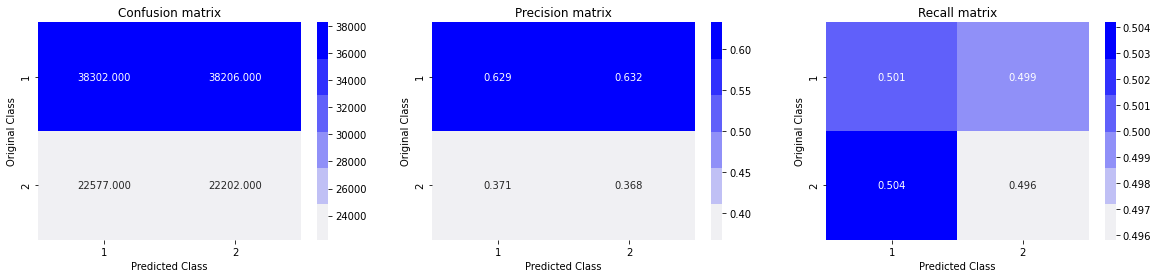

In [ ]:
predicted_y = np.zeros((len(y_test),2))

for i in range(len(y_test)):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

## Creating Multi-Channel Neuarl Network

In [ ]:
left_input = layers.Input(shape=(500, ))
right_input = layers.Input(shape=(500, ))

In [ ]:
embed_layer = layers.Embedding(vocab_size, 100, input_length=500, weights=[embedding_weights], trainable=False)

In [ ]:
q1_embed = embed_layer(left_input)
q2_embed = embed_layer(right_input)

In [ ]:
q1_flat = layers.Flatten()(q1_embed)
q1_final = layers.Dense(64, activation='relu')(q1_flat)

q2_flat = layers.Flatten()(q2_embed)
q2_final = layers.Dense(64, activation='relu')(q2_flat)

In [ ]:
numeric_input = layers.Input(shape=(10, ))

In [ ]:
united = layers.Subtract()([q1_final, q2_final])
united = layers.Concatenate(axis=1)([united, numeric_input])
output = Dense(1, activation='sigmoid')(united)

In [ ]:
model = Model(inputs=[left_input, right_input, numeric_input], outputs=[output])

model.compile(optimizer=optimizers.Adam(),loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(), 'accuracy'])

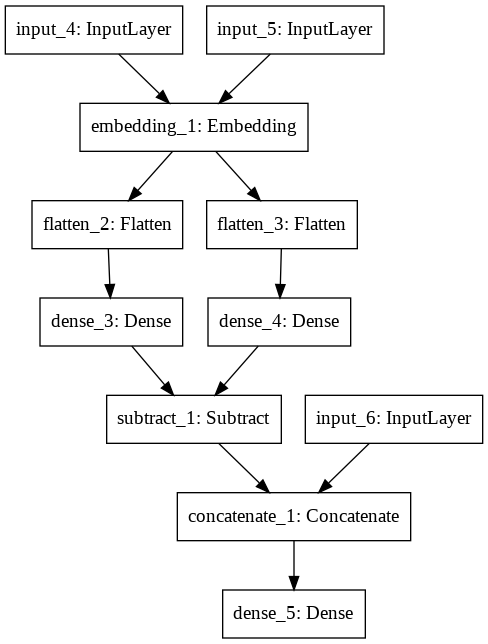

In [ ]:
utils.plot_model(model)

## Defining Model Checkpoint and Schedular

In [ ]:
# Defining model callbacks
reduce_lr_loss = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, epsilon=1e-4, mode='min')

checkpoint_path = '/content/drive/MyDrive/Data/Quora/final_model.hdf5'

cb_checkpt = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=0, save_best_only=True, 
                            save_weights_only=False, mode='min')

## Training the model

In [ ]:
history = model.fit([sequence1_train, sequence2_train, numeric_train], y_train, 
                    validation_data = ([sequence1_test, sequence2_test, numeric_test], y_test),
            epochs=5, batch_size=32, callbacks=[reduce_lr_loss, cb_checkpt])

Epoch 1/5
8844/8844 [==============================] - 68s 8ms/step - loss: 0.4313 - auc_1: 0.8683 - accuracy: 0.7830 - val_loss: 0.4036 - val_auc_1: 0.8897 - val_accuracy: 0.7965
Epoch 2/5
8844/8844 [==============================] - 66s 7ms/step - loss: 0.3879 - auc_1: 0.8963 - accuracy: 0.8081 - val_loss: 0.3912 - val_auc_1: 0.8951 - val_accuracy: 0.8065
Epoch 3/5
8844/8844 [==============================] - 65s 7ms/step - loss: 0.3707 - auc_1: 0.9060 - accuracy: 0.8184 - val_loss: 0.3894 - val_auc_1: 0.8955 - val_accuracy: 0.8099
Epoch 4/5
8844/8844 [==============================] - 64s 7ms/step - loss: 0.3552 - auc_1: 0.9142 - accuracy: 0.8276 - val_loss: 0.3985 - val_auc_1: 0.8940 - val_accuracy: 0.8094
Epoch 5/5
8844/8844 [==============================] - 64s 7ms/step - loss: 0.3397 - auc_1: 0.9220 - accuracy: 0.8369 - val_loss: 0.3942 - val_auc_1: 0.8959 - val_accuracy: 0.8139


## Analysis of model results

In [ ]:
history.history.keys()

dict_keys(['loss', 'auc_1', 'accuracy', 'val_loss', 'val_auc_1', 'val_accuracy', 'lr'])

Text(0, 0.5, 'AUC')

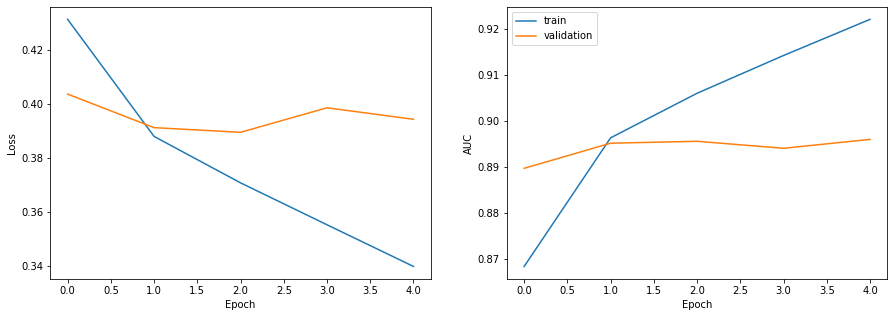

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(history.epoch, history.history['loss'], label='train')
plt.plot(history.epoch, history.history['val_loss'], label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.subplot(1,2,2)
plt.plot(history.epoch, history.history['auc_1'],label='train')
plt.plot(history.epoch, history.history['val_auc_1'], label='validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('AUC')